# Executive Compensation Dataset:

The executive compensation dataset contains detailed information about the payments made by not-for-profits to its highest compensated employees.  Thresholds include - officers, directors, trustees, key employees (>150K), and five highest compensated (>100K) employees.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px
# plt.style.use('bmh')


import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### enrich this dataset by including median income for each state
https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations

The dataset originally developed for real estate and business investment research. Income is a vital element when determining both quality and socioeconomic features of a given geographic location. The following data was derived from over +36,000 files and covers 348,893 location records.

## IMPORT DATA & PREPROCESS

In [2]:
# import USA state abbreviations 
# and median income for each state data
us_states = pd.read_csv('02.data/us_states.csv', index_col=0)
median_income_by_state = pd.read_csv('02.data/median_income_by_state.csv',
                                     skiprows=lambda x: x in [0, 1, 3], 
                                     skipfooter=9, engine='python', index_col=0)

median_income_by_state = us_states.merge(median_income_by_state,
               left_index=True,
               right_index=True)

In [3]:
# import compensation dataset with full columns
df_original = pd.read_csv('02.data/primary_raw_datasets/Compensation_charities_Open990.csv', 
                 header=1, nrows=5)

In [4]:
df_original.head(1)

,EIN,Period,Person ID,Title,Hours,Hours related org,Trustee or director,Institutional trustee,Officer,Key employee,Highest compensated,Former,Reportable comp,Reportable comp related org,Other comp all,Health and benefits,Other comp,Base,Base related org,Bonus,Bonus related org,Other,Other related org,Retire,Retire related org,Nontax benefit,Nontax benefit related org,Sum comp,Sum comp related org,Prior deferred,Prior deferred related org,Org name,Subsection,NTEE code,NTEE description,Street,City,State,ZIP,Formation yr,Phone,Website,Assets,Liabilities,Expenses,Revenue,Form type,Efile ID
0,10877614,201712,y7drw7umAm8SK9fWY7aFCA,BOARD MEMBER,1.0,NaN,True,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",4201 E 16TH ST,INDIANAPOLIS,IN,46201,2006,3174960916,WWW.HEARTCHANGEINDY.ORG,2112293,92283,500749,1792933,990,201803199349308805


In [76]:
# import columns that interest me
cols = ['EIN',
       'Period',
       'Title',
        'Hours', 
       'Trustee or director',
       'Institutional trustee',
        'Officer',
        'Key employee',
        'Highest compensated',
        'Reportable comp',
        'Health and benefits',
        'Other comp',
       'Sum comp', 
        'Org name',
        'Subsection',
        'NTEE code',
        'NTEE description',
       'State',
       'Formation yr',
       'Assets',
        'Liabilities',
        'Expenses',
        'Revenue']

df = pd.read_csv('02.data/primary_raw_datasets/Compensation_charities_Open990.csv', 
                 header=1,
                usecols=cols)

In [77]:
df.shape

(3990749, 23)

In [78]:
# convert column labels to lower case and remove spaces from column names
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)

In [81]:
# add median age for the state of each not-for-profit
df = df.merge(median_income_by_state,
        left_on='state',
        right_on='Abbreviation').drop('Abbreviation', axis=1)

### Narrow dataset based on hours and earnings for each employee

In [82]:
# exclude people who make less than median income
# for the state the the not-for-profit is located in
df = df[(df.reportable_comp > df.state_median_income) &
       (df.hours > 40)]

By excluding people who make less than the median income for the state the not-for-profit is located in, and by excluding anyone who works less than 40 hours a week, I feel confident I am only including core executive management versus part time board members or trustees.

In [85]:
# examine size of dataset
df.shape

(43274, 24)

### Narrow dataset based on title of employee

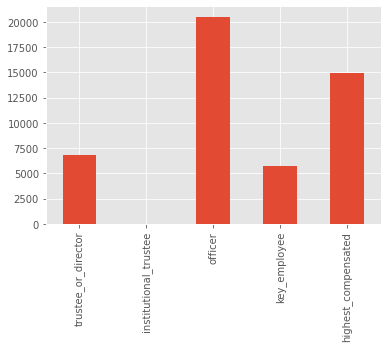

In [12]:
# what is the distribution
# based on the title of the person receiving the compensation?
df.loc[:, 'trustee_or_director': 'highest_compensated'].notnull().sum().plot(kind='bar')

Based on people who appear to be getting paid for a full time position and who are also working more than 40 hours a week, officer has the highest count.

In [13]:
df.loc[df.officer == True, 'title'].value_counts().head()

EXECUTIVE DIRECTOR    1546
PRESIDENT             1098
CEO                    916
CFO                    647
President              496
Name: title, dtype: int64

In [14]:
df.loc[df.trustee_or_director == True, 'title'].value_counts().head()

PRESIDENT             521
EXECUTIVE DIRECTOR    332
DIRECTOR              271
President             268
Director              206
Name: title, dtype: int64

In [15]:
df.loc[df.key_employee == True, 'title'].value_counts().head()

Executive Director    154
EXECUTIVE DIRECTOR    147
CEO                    75
GENERAL MANAGER        73
PRESIDENT              61
Name: title, dtype: int64

In [16]:
df.loc[df.highest_compensated == True, 'title'].value_counts().head()

PHYSICIAN             1095
Physician              363
EXECUTIVE DIRECTOR     137
Executive Director     119
CONTROLLER             108
Name: title, dtype: int64

By examination of the titles of "Highest Compensated" employees, most of these are highly skilled trades, versus executive leadership.  As a result I will exclude people who fall into this category.

In [88]:
# drop highest compensated employees
df.drop(df.loc[df.highest_compensated == True].index, inplace=True)

In [90]:
# examine for nan values
df.isna().sum()

ein                          0
period                       0
title                      866
hours                        0
trustee_or_director      21714
institutional_trustee    28271
officer                   8160
key_employee             22929
highest_compensated      28286
reportable_comp              0
health_and_benefits      28178
other_comp               28199
sum_comp                  9281
org_name                     0
subsection                   0
ntee_code                   85
ntee_description            85
state                        0
formation_yr              1282
assets                       0
liabilities                 36
expenses                     0
revenue                      0
state_median_income          0
dtype: int64

In [91]:
# drop rows with missing values in these columns
df.dropna(subset=['ntee_code'], inplace=True)

In [94]:
# fillna for formation_year
# I may want to do this with random forest instead
df.formation_yr.fillna(df.formation_yr.median(), inplace=True)
df.formation_yr = df.formation_yr.astype(int)

In [95]:
# fillna for orgs with missing liabilities
df.liabilities.fillna(df.liabilities.median(), inplace=True)

In [97]:
# examine columns with missing values
# the small percentage of missing values 
# in these columns is acceptable to me
df.isna().mean()

ein                      0.000000
period                   0.000000
title                    0.030708
hours                    0.000000
trustee_or_director      0.768873
institutional_trustee    0.999468
officer                  0.287401
key_employee             0.810716
highest_compensated      1.000000
reportable_comp          0.000000
health_and_benefits      0.996206
other_comp               0.996950
sum_comp                 0.328676
org_name                 0.000000
subsection               0.000000
ntee_code                0.000000
ntee_description         0.000000
state                    0.000000
formation_yr             0.000000
assets                   0.000000
liabilities              0.000000
expenses                 0.000000
revenue                  0.000000
state_median_income      0.000000
dtype: float64

## PRELIMINARY EDA

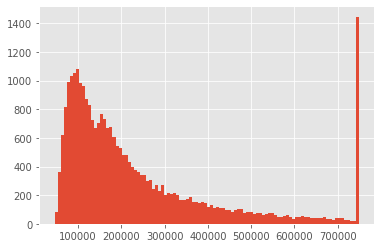

In [25]:
# clipping at the 95% percentile, what is the distribution?
plt.hist(df.reportable_comp.clip(upper=df.reportable_comp.quantile(.95)), bins=100);

The reason for the spike at 100K is because that is the threshold above which not-for-profit organizations are required to disclose salaries.  Clearly a large number of organizations are disclosing, even when not required.

## FEATURE ENGINEERING

#### Remove noise from NTEE codes

In [98]:
# to more broadly categorize not-for-profits
# strip off the letter from the ntee code
df['ntee_letter'] = df.ntee_code.apply(lambda x: x[0:1])

#### Find percentage of total executive compensation for each org for each executive paid


In [99]:
# find total reportable comp for each ein
df.groupby('ein')['reportable_comp'].sum().astype(int).rename('total_ex_comp_per_company')

ein
10056837      200807
10095740      410827
10124810       76339
10130427      237594
10165110      115778
              ...   
990342356     989962
990346113    1299181
990347826     410040
996008848     129494
996009889     172346
Name: total_ex_comp_per_company, Length: 12688, dtype: int32

In [100]:
# join this amount based on ein
# to each person who was paid
df = df.merge(df.groupby('ein')['reportable_comp']
              .sum()
              .astype(int)
              .rename('total_ex_comp_per_company'),
        left_on='ein',
        right_on='ein')

In [101]:
df.head()

,ein,period,title,hours,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,health_and_benefits,other_comp,sum_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_letter,total_ex_comp_per_company
0,10877614,201712,BOARD MEMBER/MANAGING D,65.0,True,NaN,NaN,NaN,NaN,55385.0,NaN,NaN,NaN,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006,2112293,92283.0,500749.0,1792933.0,54181,G,55385
1,200160286,201812,EXECUTIVE DI,50.0,NaN,NaN,True,NaN,NaN,86057.0,NaN,NaN,NaN,THE TONY STEWART FOUNDATION INC,501(c)(3),P20,Human Service Organizations - Multipurpose,IN,2003,2509180,47699.0,628058.0,648782.0,54181,P,86057
2,202804389,201806,EXECUTIVE DIRECTOR,60.0,True,NaN,NaN,NaN,NaN,110000.0,NaN,NaN,NaN,HILLEL FOUNDATION AT INDIANA UNIVERSITY INC,501(c)(3),B11,Monetary support - Education,IN,1950,2513661,108461.0,707744.0,688050.0,54181,B,110000
3,203222424,201812,EXECUTIVE DIRECTOR,50.0,NaN,NaN,True,NaN,NaN,80195.0,NaN,NaN,NaN,THE IMMIGRANT WELCOME CENTER INC,501(c)(3),P84,"Ethnic, Immigrant Centers, Services",IN,2006,1338409,27275.0,328093.0,421622.0,54181,P,80195
4,203901164,201806,VP OF FINANCE,56.0,NaN,NaN,True,NaN,NaN,127402.0,NaN,NaN,148799.0,THE CENTER FOR THE PERFORMING ARTS INC,501(c)(3),A12,Monetary support - Arts &amp; culture,IN,2006,6954431,1276801.0,7967667.0,8641179.0,54181,A,127402


In [102]:
df['percent_of_total_ex_comp'] = df.reportable_comp/df.total_ex_comp_per_company

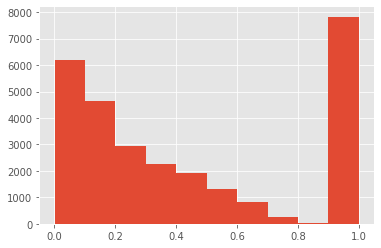

In [103]:
plt.hist(df.percent_of_total_ex_comp);

Executives are clearly bifurcated between those who are the only executive with that organization and those who are part of a larger organization with lots of executives.

In [51]:
df.head()

,ein,period,title,hours,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,health_and_benefits,other_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_letter,total_ex_comp_per_company,percent_of_total_ex_comp
0,10877614,201712,BOARD MEMBER/MANAGING D,65.0,True,NaN,NaN,NaN,NaN,55385.0,NaN,NaN,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,54181,G,55385.0,1.0
1,200160286,201812,EXECUTIVE DI,50.0,NaN,NaN,True,NaN,NaN,86057.0,NaN,NaN,THE TONY STEWART FOUNDATION INC,501(c)(3),P20,Human Service Organizations - Multipurpose,IN,2003.0,2509180,47699.0,628058.0,648782.0,54181,P,86057.0,1.0
2,202804389,201806,EXECUTIVE DIRECTOR,60.0,True,NaN,NaN,NaN,NaN,110000.0,NaN,NaN,HILLEL FOUNDATION AT INDIANA UNIVERSITY INC,501(c)(3),B11,Monetary support - Education,IN,1950.0,2513661,108461.0,707744.0,688050.0,54181,B,110000.0,1.0
3,203222424,201812,EXECUTIVE DIRECTOR,50.0,NaN,NaN,True,NaN,NaN,80195.0,NaN,NaN,THE IMMIGRANT WELCOME CENTER INC,501(c)(3),P84,"Ethnic, Immigrant Centers, Services",IN,2006.0,1338409,27275.0,328093.0,421622.0,54181,P,80195.0,1.0
4,203901164,201806,VP OF FINANCE,56.0,NaN,NaN,True,NaN,NaN,127402.0,NaN,NaN,THE CENTER FOR THE PERFORMING ARTS INC,501(c)(3),A12,Monetary support - Arts &amp; culture,IN,2006.0,6954431,1276801.0,7967667.0,8641179.0,54181,A,127402.0,1.0


### EXPORT DATASET FOR MODELING

cleaned/organized dataset with added features - export for modeling

In [106]:
# select columns to use for modeling
list(enumerate(df.columns))

[(0, 'ein'),
 (1, 'period'),
 (2, 'title'),
 (3, 'hours'),
 (4, 'trustee_or_director'),
 (5, 'institutional_trustee'),
 (6, 'officer'),
 (7, 'key_employee'),
 (8, 'highest_compensated'),
 (9, 'reportable_comp'),
 (10, 'health_and_benefits'),
 (11, 'other_comp'),
 (12, 'sum_comp'),
 (13, 'org_name'),
 (14, 'subsection'),
 (15, 'ntee_code'),
 (16, 'ntee_description'),
 (17, 'state'),
 (18, 'formation_yr'),
 (19, 'assets'),
 (20, 'liabilities'),
 (21, 'expenses'),
 (22, 'revenue'),
 (23, 'state_median_income'),
 (24, 'ntee_letter'),
 (25, 'total_ex_comp_per_company'),
 (26, 'percent_of_total_ex_comp')]

In [107]:
pd.concat([df.iloc[:,[0, 9, 14]],
           df.iloc[:,17:]], axis=1)

,ein,reportable_comp,subsection,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_letter,total_ex_comp_per_company,percent_of_total_ex_comp
0,10877614,55385.0,501(c)(3),IN,2006,2112293,92283.0,500749.0,1792933.0,54181,G,55385,1.0
1,200160286,86057.0,501(c)(3),IN,2003,2509180,47699.0,628058.0,648782.0,54181,P,86057,1.0
2,202804389,110000.0,501(c)(3),IN,1950,2513661,108461.0,707744.0,688050.0,54181,B,110000,1.0
3,203222424,80195.0,501(c)(3),IN,2006,1338409,27275.0,328093.0,421622.0,54181,P,80195,1.0
4,203901164,127402.0,501(c)(3),IN,2006,6954431,1276801.0,7967667.0,8641179.0,54181,A,127402,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28196,830219163,180954.0,501(c)(3),WY,1974,53499937,3661232.0,14767259.0,14292836.0,60434,A,180954,1.0
28197,830222330,78435.0,501(c)(3),WY,1972,10188998,517387.0,4164759.0,3893887.0,60434,P,78435,1.0
28198,830235044,89790.0,501(c)(3),WY,1977,2546933,358499.0,2867628.0,3274645.0,60434,F,89790,1.0
28199,830236714,112000.0,501(c)(6),WY,1984,1251622,799646.0,629673.0,596243.0,60434,W,112000,1.0


In [108]:
pd.concat([df.iloc[:,[0, 9, 14]],
           df.iloc[:,17:]], axis=1).to_csv('02.data/executive_comp_data.csv', index=False)

## SPARE PARTS

### Title analysis
This is a fill in the blank field, as a result there are a huge number of unique values.

In [73]:
df.title.nunique()

7035

In [357]:
df.title.value_counts().head(10)

DIRECTOR              5518
PRESIDENT             2353
Director              2170
TRUSTEE               1702
BOARD MEMBER          1507
EXECUTIVE DIRECTOR    1452
SECRETARY             1115
TREASURER             1057
President             1009
VICE PRESIDENT         832
Name: title, dtype: int64

In [356]:
# how many trustees/directors
# have multiple roles listed within their title?
df[(~df.title.isna()) &
  (df.title.str.contains('/'))].shape

(4140, 16)

### Verify I can join governance EINs with Executive comp EINs

In [130]:
ein = pd.read_csv('data_sets/ein.csv')

In [131]:
ein.set_index('ein').index.intersection(df['ein'].reset_index().set_index('ein').index)

Int64Index([ 61594980,  61594980, 311424220, 311424220, 311424220, 311424220,
            141056009, 141056009, 141056009, 141056009,
            ...
            952149001, 952149001, 952149001,  43528015, 472330028, 475285597,
            474202980, 474202980, 474202980, 364735749],
           dtype='int64', name='ein', length=38625)

### SPARE PARTS